In [1]:
from lr.models.transformers.util import load_and_cache_examples
from lr.models.transformers.util import train, set_seed, evaluate
from torch.utils.data import TensorDataset
import logging
import os
import shutil
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer
from transformers import BertForSequenceClassification


### Params

In [2]:
hyperparams = {"local_rank": -1,
               "max_seq_length": 128,
               "overwrite_cache": False,
               "cached_path":"data/toy/",
               "train_path": "data/toy/train.csv",
               "dev_path":"data/toy/dev.csv",
               "num_train_epochs":2.0,
               "per_gpu_train_batch_size":8,
               "per_gpu_eval_batch_size":8,
               "gradient_accumulation_steps": 1,
               "learning_rate":5e-5,
               "weight_decay":0.0,
               "adam_epsilon": 1e-8,
               "max_grad_norm": 1.0,
               "max_steps": -1,
               "warmup_steps": 0,
               "save_steps": 200,
               "no_cuda":False,
               "n_gpu":1,
               "model_name_or_path":"bert",
               "output_dir":"bert",
               "random_state": 42,
               "fp16":False,
               "fp16_opt_level":"01",
               "device":"cpu",
               "verbose":True,
               "model_type": "bert"}

set_seed(hyperparams["random_state"], hyperparams["n_gpu"])

pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)
model = BertForSequenceClassification.from_pretrained(pretrained_weights, num_labels = 3)


### Eval before training

In [3]:
results = evaluate(hyperparams, model, tokenizer)

(results.prediction==results.label).mean()

Evaluating: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


0.36

## Creating features

In [4]:
train_dataset = load_and_cache_examples(hyperparams, tokenizer)

In [5]:
dev_dataset = load_and_cache_examples(hyperparams, tokenizer, evaluate=True)

## train

In [6]:
global_step, tr_loss = train(train_dataset, model, tokenizer, hyperparams)

Epoch: 100%|██████████| 2/2 [08:09<00:00, 244.91s/it]


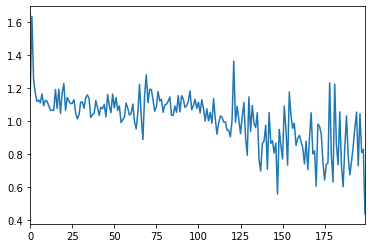

In [7]:
training_logs = pd.read_csv("bert/log.csv")
training_logs.loss.plot();

### Eval after training

In [9]:
results = evaluate(hyperparams, model, tokenizer)

(results.prediction==results.label).mean()

Evaluating: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


0.485

### Check labels

In [10]:
from lr.training.util import get_positive_labels

values = get_positive_labels(pd.read_csv("data/toy/dev.csv"))
assert np.all(results.label.values == values)

In [13]:
if os.path.exists("example.log"):
    os.remove("example.log")
    
    
if os.path.exists("bert"):
    shutil.rmtree("bert")